In [1]:
import math
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sin_wave(A, omega, fai, length):
	# A*sin(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.sin(x - fai)
def cos_wave(A, omega, fai, length):
	# A*cos(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.cos(x - fai)

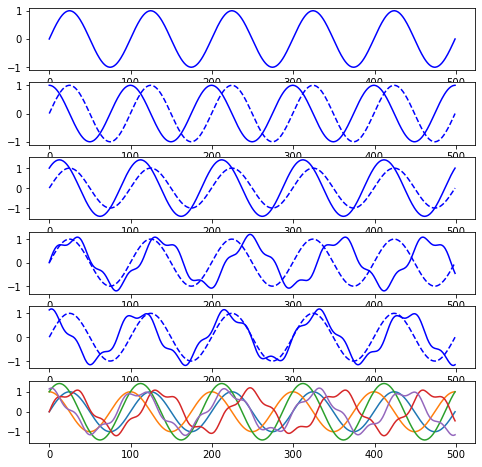

In [3]:
x1 = sin_wave(1, 100, 0, 500)
x2 = cos_wave(1, 100, 0, 500)
x3 = sin_wave(1, 100, 0, 500) + cos_wave(1, 100, 0, 500)
x4 = sin_wave(1, 110, 0, 500) + sin_wave(0.2, 30, 0, 500)
x5 = cos_wave(1, 110, 0, 500) + sin_wave(0.2, 30, -np.pi/4, 500)
X = np.array([x1,x2,x3,x4,x5]).T

plt.figure(figsize=(8,8))
plt.subplot(611)
plt.plot(x1,color='b')
plt.subplot(612)
plt.plot(x2,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(613)
plt.plot(x3,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(614)
plt.plot(x4,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(615)
plt.plot(x5,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(616)
plt.plot(X)

In [4]:
def missing_matrix(X, missing_len=0.05, missing_num=10):
	#連続した欠損値を生成する
	#X = (Time, dim)
	#missing_len 全体の長さ(Time)のうちどれだけの割合を欠損値にするか
	#missing_num 欠損値の数
	#W: if X[i,j] == nan then W[i,j] == 0 else W[i,j] == 1

	W = np.ones(X.shape)
	(r, l) = X.shape
	#missing_point[[row, startpoint, length],[],...]
	missing_points = [[random.randint(0,l-1), random.randint(0,r-1), random.randint(0,int(r*missing_len))] for i in range(missing_num)]

	for point in missing_points:
		if point[1]+point[2]>=r:
			end=r-1
		else:
			end=point[1]+point[2]
		W[point[1]:end, point[0]] = 0
	return W

def to_missing_X(X, W):
	W_nan = copy.copy(W)
	W_nan[W_nan==0]=np.nan
	missing_X = X * W_nan
	return missing_X

def interpolate_matrix(X, how):
	#線形補完
	initial_X = pd.DataFrame(X).interpolate(method=how)
	#最後にnanがあるなら直前の値で埋める
	initial_X = initial_X.fillna(method='ffill')
	#最初にnanがあるなら直後の値で埋める
	initial_X = initial_X.fillna(method='bfill')
	return np.array(initial_X)

number of missing value 267


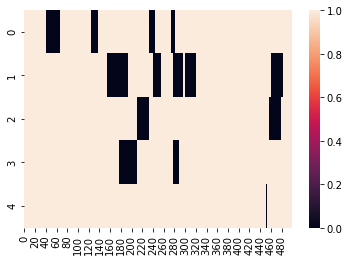

In [18]:
W = missing_matrix(X,missing_len=0.05, missing_num=20)
#missing values are black
sns.heatmap(W.T)
missing_X = to_missing_X(X, W)
linear_X = interpolate_matrix(missing_X, how='linear')
initial_X = copy.copy(linear_X)
print('number of missing value', np.count_nonzero(np.isnan(missing_X)))

In [19]:
class MSVD(object):
	def __init__(self, H):
		#H: hidden dimensions for SVD
		self.H = H

	def fit(self, X, W, n_iter):

		hidden=self.H
		for _ in range(n_iter):
			#SVD
			U, s, V = np.linalg.svd(X, full_matrices=False)
			S = np.diag(s)
			Y = U[:, :hidden] @ S[:hidden, :hidden] @ V[:hidden, :]

			#欠損値なら更新する
			for i in range(W.shape[0]):
				for j in range(W.shape[1]):
					if W[i,j]==0:
						X[i,j] = Y[i,j]
		
		return X

In [20]:
hidden_dimension=3
msvd = MSVD(hidden_dimension)
msvd_X = msvd.fit(initial_X, W, n_iter=100)

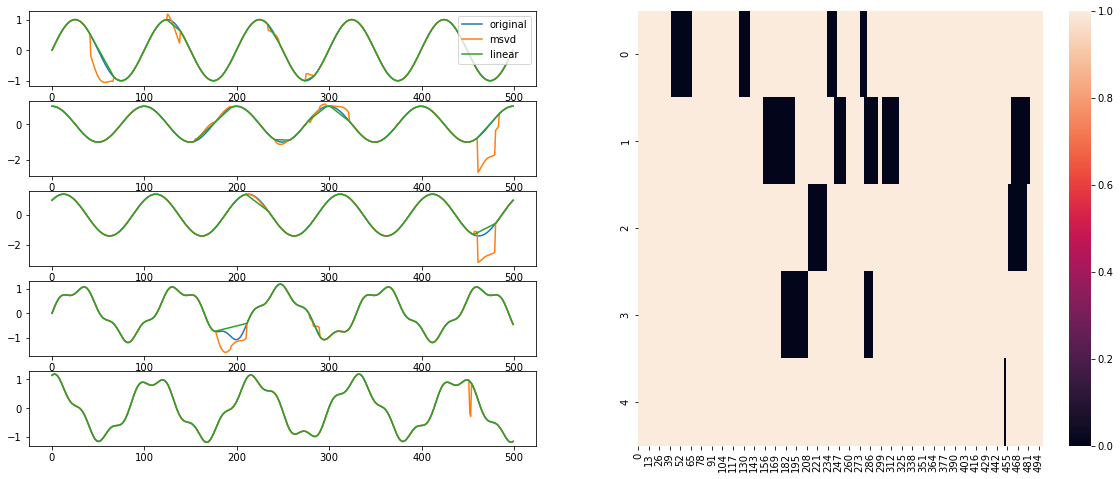

In [23]:
plt.figure(figsize=(20,8))
plt.subplot(521)
plt.plot(x1, label='original')
plt.plot(msvd_X[:,0], label='msvd')
plt.plot(linear_X[:,0], label='linear')
plt.legend()
plt.subplot(523)
plt.plot(x2, label='original')
plt.plot(msvd_X[:,1], label='msvd')
plt.plot(linear_X[:,1], label='linear')
plt.subplot(525)
plt.plot(x3, label='original')
plt.plot(msvd_X[:,2], label='msvd')
plt.plot(linear_X[:,2], label='linear')
plt.subplot(527)
plt.plot(x4, label='original')
plt.plot(msvd_X[:,3], label='msvd')
plt.plot(linear_X[:,3], label='linear')
plt.subplot(529)
plt.plot(x5, label='original')
plt.plot(msvd_X[:,4], label='msvd')
plt.plot(linear_X[:,4], label='linear')
plt.subplot(122)
sns.heatmap(W.T)